# Testing regridding suing sparse matrix multiplication

These tests use ane xtract from the [climtas](https://github.com/ScottWales/climtas/) library which already implements efficiently this idea and has no other significant dependencies (it does not use iris or esmf for regridding).
I only had to change a few lines of code to make it compatible with unstructured grids. The essence of climtas/regrid.py is basically sparse matrix multiplication using dask + some manipulation of the coordinates (which would have to be revised/checked again)


In [6]:
from dask.distributed import LocalCluster, Client, progress
cluster = LocalCluster(ip="0.0.0.0", threads_per_worker=2, n_workers=16)
client = Client(cluster)
#client = Client(ip="0.0.0.0", processes=True, threads_per_worker=8,
#               n_workers=4, memory_limit='8GB'
cluster

2022-09-09 11:08:15,324 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-ujwuk859', purging
2022-09-09 11:08:15,324 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-uxasm710', purging
2022-09-09 11:08:15,324 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-ki1lne47', purging
2022-09-09 11:08:15,324 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-h68xemou', purging
2022-09-09 11:08:15,324 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-c_g0yfk3', purging
2022-09-09 11:08:15,325 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-ojob9ap6', purging
2022-09-09 11:08:15,325 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-d4ae5tv6', purging

## Test 1: EC-Earth3 daily (165 years) to 2x2 resolution using climtas

We test climtas regridding using daily EC-Earth3 data from ESGF

In [19]:
import xarray as xr

# This is a standard ESGF folder containing daily tas from EC-Earth (point it to your own)
src =  "/work/datasets/synda/data/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r1i1p1f1/day/tas/gr/v20200310/tas*.nc"
src_ds = xr.open_mfdataset(src)

# We use this sample file to describe the target grid which we intend, 2x2 deg in this case
dest = 'data/r180x91/climate_CRU_t2m.nc'
dest_ds = xr.open_dataset(dest)


Totally optional. We initiate a cluster client with 16 workers.

We precomputed weights for these target to destination resolutions using cdo genycon (area conserving conservative remapping using the YAC algorithm)

In [16]:
# cdo genycon,data/r180x91/climate_CRU_t2m.nc /work/datasets/synda/data/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r1i1p1f1/day/tas/gr/v20200310/tas_day_EC-Earth3_historical_r1i1p1f1_gr_19660101-19661231.nc weights_ycon.nc

Now we import our reduced climtas library (this is a subset of the original at https://github.com/ScottWales/climtas)
I had to comment a few lines in regrid.py in order to make it work with unstructured grids

In [2]:
import climtas
weights = xr.open_mfdataset("weights_ycon.nc")
weights


<xarray.Dataset>
Dimensions:              (src_grid_rank: 2, dst_grid_rank: 2, src_grid_size: 131072, dst_grid_size: 16380, num_links: 239432, num_wgts: 1)
Dimensions without coordinates: src_grid_rank, dst_grid_rank, src_grid_size, dst_grid_size, num_links, num_wgts
Data variables: (12/15)
    src_grid_dims        (src_grid_rank) int32 dask.array<chunksize=(2,), meta=np.ndarray>
    dst_grid_dims        (dst_grid_rank) int32 dask.array<chunksize=(2,), meta=np.ndarray>
    src_grid_center_lat  (src_grid_size) float64 dask.array<chunksize=(131072,), meta=np.ndarray>
    dst_grid_center_lat  (dst_grid_size) float64 dask.array<chunksize=(16380,), meta=np.ndarray>
    src_grid_center_lon  (src_grid_size) float64 dask.array<chunksize=(131072,), meta=np.ndarray>
    dst_grid_center_lon  (dst_grid_size) float64 dask.array<chunksize=(16380,), meta=np.ndarray>
    ...                   ...
    dst_grid_area        (dst_grid_size) float64 dask.array<chunksize=(16380,), meta=np.ndarray>
    src_grid_frac        (src_grid_size) float64 dask.array<chunksize=(131072,), meta=np.ndarray>
    dst_grid_frac        (dst_grid_size) float64 dask.array<chunksize=(16380,), meta=np.ndarray>
    src_address          (num_links) int32 dask.array<chunksize=(239432,), meta=np.ndarray>
    dst_address          (num_links) int32 dask.array<chunksize=(239432,), meta=np.ndarray>
    remap_matrix         (num_links, num_wgts) float64 dask.array<chunksize=(239432, 1), meta=np.ndarray>
Attributes:
    title:          SCRIP remapping with CDO
    normalization:  fracarea
    map_method:     Conservative remapping using clipping on sphere
    conventions:    SCRIP
    source_grid:    gaussian
    dest_grid:      lonlat
    history:        09 Sep 2022 : cdo genycon,data/r180x91/climate_CRU_t2m.nc...
    CDO:            Climate Data Operators version 1.9.9rc1 (https://mpimet.m...

Instantiate a regridder object with the weights which we have just loaded and then apply it to regrid tas from the sample source dataset

In [3]:
regridder = climtas.regrid.Regridder(weights=weights)

In [4]:
tasr = regridder.regrid(src_ds.tas)

/home/jost/miniconda3/envs/cats/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3338: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  if await self.run_code(code, result, async_=asy):


Let's give a look at the resulting tasr array. It is still dask chunked.

In [5]:
tasr

<xarray.DataArray 'tas' (time: 60265, lat: 91, lon: 180)>
dask.array<reshape, shape=(60265, 91, 180), dtype=float64, chunksize=(366, 91, 180), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1850-01-01T12:00:00 ... 2014-12-31T12:00:00
    height   float64 2.0
  * lat      (lat) float64 dask.array<chunksize=(91,), meta=np.ndarray>
  * lon      (lon) float64 dask.array<chunksize=(180,), meta=np.ndarray>

Compute something useful (and finally do the calculation)

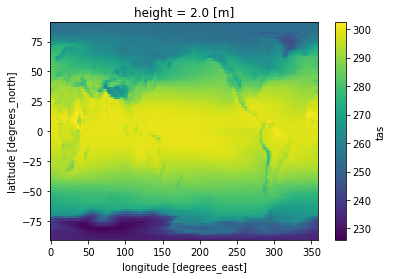

In [7]:
tasr.mean(dim="time").plot()

This takes about 20s on my machine with 16 workers, sweet.

## Interlude: the same with xesmf

Here we test it with xesmf, but using bilinear interpolation (it throws an error if I try and use conservative)

In [9]:
import xesmf as xe

interp = xe.Regridder(src_ds, dest_ds, periodic = False, method = "bilinear")


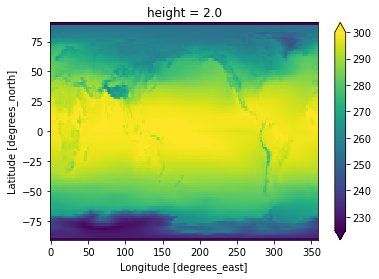

In [11]:
interp(src_ds['tas']).mean(dim="time").plot(vmin=225, vmax=300)

About the same time (16s on my machine).

## Test 2: More serious stuff, ICON 5km data (original grid) again to 2x2deg grid

This is something which (apparently) at the moment we cannot do with xesmf since the source data are on an unstructured grid.

In [19]:
import xarray as xr

# This is sample data downloaded from dkrz at /work/bm1235/k203123/experiments/ngc2009
src =  "/home/jost/work/destine/nextgems/ngc2009_atm_2d_30min_inst_20220225T000000Z.nc"
src_ds = xr.open_mfdataset(src)

# We use this sample file to describe the target grid which we intend, 2x2 deg in this case
dest = 'data/r180x91/climate_CRU_t2m.nc'
dest_ds = xr.open_dataset(dest)


Precomputed weights using CDO

In [ ]:
# cdo genycon,data/r180x91/climate_CRU_t2m.nc ../../destine/nextgems/ngc2009_atm_2d_30min_inst_20220225T000000Z.tas.nc weights_icon_ycon.nc

In [2]:
weights = xr.open_mfdataset("weights_icon_ycon.nc")

and now we use climtas regridding using the precomputed weights. Notice that the package also proivides functions to call cdo or ESMF and compute the weights from inside python. It recognizes automatically (from the filename) if weights are CDO or ESMF style.

In [3]:
import climtas
regridder = climtas.regrid.Regridder(weights=weights)

In [4]:
tasr = regridder.regrid(src_ds.tas)

In [17]:
tasr

<xarray.DataArray 'tas' (time: 48, lat: 91, lon: 180)>
dask.array<reshape, shape=(48, 91, 180), dtype=float64, chunksize=(48, 91, 180), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2022-02-25 ... 2022-02-25T23:30:00
  * lat      (lat) float64 dask.array<chunksize=(91,), meta=np.ndarray>
  * lon      (lon) float64 dask.array<chunksize=(180,), meta=np.ndarray>

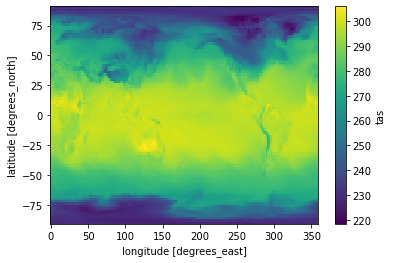

In [5]:
tasr.mean(dim="time").plot()

20s on my machine ! This is really cool. 

## FESOM example

In [12]:
import xarray as xr

# This is sample data downloaded from https://swift.dkrz.de/v1/dkrz_0262ea1f00e34439850f3f1d71817205/FESOM/tos_Omon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-185012.nc
src =  "/work/users/jost/destine/fesom/tos_Omon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-185012.nc"
src_ds = xr.open_mfdataset(src)

# We use this sample file to describe the target grid which we intend, 2x2 deg in this case
dest = 'data/r180x91/climate_CRU_t2m.nc'
dest_ds = xr.open_mfdataset(dest)


Precompute weights

In [8]:
# cdo genycon,/work/users/jost/aqua/AQUA/playground/regrid/data/r180x91/climate_CRU_t2m.nc  tos_Omon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-185012.nc weights_fesom.nc

There is some issue in how climtas interprets time, I have to try with only one timeslice for now

In [13]:
import climtas
weights = xr.open_dataset("weights_fesom.nc")
regridder = climtas.regrid.Regridder(weights=weights)
tosr = regridder.regrid(src_ds.tos[0,:])


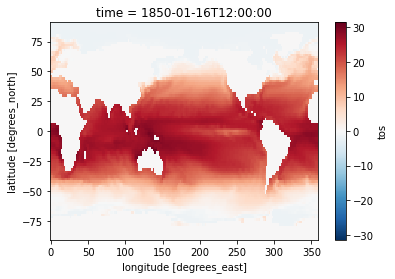

In [15]:
tosr.plot()